# Experiments Pertaining to 

#### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random
from pathlib import Path
from collections import OrderedDict
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
#import missingno as mso
#import pandas_profiling as pdp

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

from torchvision import models
import torchvision.transforms as T
#from torchvision.utils import make_grid
#from efficientnet_pytorch import EfficientNet
#import torchsummary
# local files
from plotting import show_batch, plot_learning_curves
from modeling import CheXModel

C:\Users\Rygu\Anaconda3\envs\mldl\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


#### Globals

In [2]:
USE_CUDA = True
ON_AWS = True
NUM_WORKERS = 4 if ON_AWS else 0 
DEVICE = torch.device('cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu')

In [3]:
SEED = 404
def seed_everything(seed=SEED, env=None):
    random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [4]:
PATH_DATA = Path('data/')
chxpath = PATH_DATA/'CheXpert-v1.0-small/'
path_train = chxpath/'train'
path_valid = chxpath/'valid'

In [9]:
TARGET_LABELS = ['No_Finding', 'Enlarged_Cardiomediastinum', 'Cardiomegaly',
       'Lung_Opacity', 'Lung_Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural_Effusion', 'Pleural_Other',
       'Fracture', 'Support_Devices']

## Data

In [5]:
df_train = pd.read_csv(chxpath/'train.csv')
df_valid = pd.read_csv(chxpath/'valid.csv')

In [51]:
def label_smooth(df, method='uones', smooth_bounds=None):
    df_sub = df.copy()
    if smooth_bounds is None:
        eps = 1e-5
        if method == 'uones':
            smooth_bounds = (0.55, 0.85+eps)
        elif method=='uzeros':
            smooth_bounds = (0, 0.30+eps)
        else:
            smooth_bounds = (0, 0.85+eps)
    
    if method in ['uones','uzeros']:
        smooth_distrb = np.random.uniform(*smooth_bounds,df_sub[TARGET_LABELS].shape)
        df_sub.loc[:,TARGET_LABELS] = np.where(df_sub[TARGET_LABELS]==-1, smooth_distrb, df_sub[TARGET_LABELS])
        
    return df_sub

def proc_df(df, method='uones', smooth=True, nafill_val=0, ufill_val=1, **kwargs):
    """
    Preprocess dataframe for model consumption
    
    Args:
        df (pandas.DataFrame): dataframe containing img paths, metadata, and labels.
        method (str), ('uzeros','uones','constant'): method for replacing uncertainty labels (default: 'uones')
        smooth (bool): use Label Smoothing Regression (LSR) only applies when `method`=('uzeros','uones') (default: True) 
        nafill_val (int,float): value used to fill nan values (default: 0)
        ufill_val (int,float): value used to fill -1 (uncertainty) labels
    
    kwargs:
        smooth_bounds (tuple(float,float)): replace -1 labels uniform random values between the given bounds
        (default: `method`='uzeros': (0,0.3001), `method`='uones': (0.55,0.8501) when `Smooth`=True, 
                
    Returns:
        processed_df: pandas.Dataframe
    """
    
    is_val = df['Path'].str.contains('valid').all()
    df_sub = df.rename(lambda x: x.replace(' ','_'), axis=1).drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])
    
    if is_val:
        return df_sub # val set has no nans, no -1s
    
    df_targets = df_sub[TARGET_LABELS]
    
    if isinstance(nafill_val,tuple):
        nan_smooth_distrb = np.random.uniform(*nafill_val, df_targets.shape)
        df_sub.loc[:,TARGET_LABELS] = np.where(df_targets.isna(), nan_smooth_distrb, df_targets)
    else:
        df_sub = df_sub.fillna(nafill_val)
    
    if smooth:
        df_sub = label_smooth(df_sub, method, kwargs.get('smooth_bounds'))
    elif method == 'constant':
        df_sub = df_sub.replace(-1,ufill_val)
    elif method in ['uzeros','uones'] and ufill_val not in [0.0,1.0]:
        print(f'WARNING: Overwritting `ufill_val` to match method "{method}"')
        ufill_val = 1.0 if method=='uones' else 0.0
        df_sub = df_sub.replace(-1,ufill_val)
    
    df_sub.loc[:,TARGET_LABELS] = df_sub.loc[:,TARGET_LABELS].astype(float)
    
    return df_sub

## Image Augmentations

In [157]:
FRONTAL_TEMPLATE1c = cv2.imread('templates/fnt_ext_template244.jpg', 0)
LATERAL_TEMPLATE1c = cv2.imread('templates/lat_ext_template244.jpg', 0)

def template_match(img, template, tm_method=cv2.TM_CCOEFF_NORMED, init_resize=(256,256)):
    h,w = template.shape
    if img.ndim > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img1c256 = cv2.resize(img, init_resize, interpolation=cv2.INTER_LINEAR)

    res = cv2.matchTemplate(img1c256, template, tm_method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = max_loc if tm_method not in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else min_loc
    bottom_right = (top_left[0] + w, top_left[1]+h)
    (x,y),(x1,y1) = top_left, bottom_right
    
    return cv2.cvtColor(img1c256[y:y1, x:x1], cv2.COLOR_GRAY2BGR)

In [158]:
class TemplateCrop(A.ImageOnlyTransform):
    """Match image to template of either a lateral or frontal view, resizing and cropping in the process.
    Args:
        tm_method (int): Template matching method
    Targets:
        image
    Image types:
        uint8, float32
    """

    def __init__(self, tm_method=cv2.TM_CCOEFF_NORMED, init_resize=(256,256), always_apply=False, p=1.0):
        super(TemplateCrop, self).__init__(always_apply, p)
        self.tm_method = tm_method
        self.init_resize = init_resize

    def apply(self, image, **params):
        template = LATERAL_TEMPLATE1c if params.get('is_lateral') else FRONTAL_TEMPLATE1c
        return template_match(image, template, self.tm_method, self.init_resize)

    def get_transform_init_args_names(self):
        return ("tm_method","init_resize")

In [452]:
def advprop(image,**kwargs):
    return image*2.0-1.0
def get_transforms(varient='train', tfms_lib='albu', imgsize=(244,244)):
    if tfms_lib == 'albu':
        transform = A.Compose([
            A.RandomScale((-0.02,0.02)),
            A.OneOf([
                TemplateCrop(init_resize=(256, 256), p=1.0),
                A.Compose([A.Resize(256,256, p=1.0),A.CenterCrop(*imgsize, p=1.0)])
            ],p=1.0),
            A.CLAHE(p=0.5),
            A.HorizontalFlip(),
            A.Rotate((-7,7)),#,border_mode=cv2.BORDER_CONSTANT),
            A.IAAAffine(shear=(-5,5)),
            A.Cutout(8,8,8),
            
            #A.Lambda(advprop),
            A.Normalize(),
            ToTensorV2(),
        ])
        
        tta_augments = A.Compose([
            A.OneOf([
                TemplateCrop(init_resize=(256, 256), p=1.0),
                A.Compose([A.Resize(256,256, p=1.0), A.CenterCrop(*imgsize,p=1.0)])
            ],p=1.0),
            A.OneOf([
                A.HorizontalFlip(),
                A.Rotate((-7,7)),#border_mode=cv2.BORDER_CONSTANT),
                A.IAAAffine(shear=(-5,5)),
                A.NoOp()
            ],p=1.0),
            A.Normalize(),
            ToTensorV2()
        ])
        
    elif tfms_lib == 'torch':
        transform = T.Compose([
            #T.RandomCrop(512,8,padding_mode='reflect') ,
            T.CenterCrop(imgsize),
            T.RandomHorizontalFlip(),
            T.RandomRotation(7),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
            #T.RandomErasing(inplace=True)
        ])
        tta_augments = T.Compose([T.CenterCrop(32),T.ToTensor()])
        
    return transform if varient == 'train' else tta_augments

## Dataset / DataLoader

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# (blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive)
class CheXDataset(Dataset):
    def __init__(self, df, use_albu=True, tfms=None, smooth_bounds=None, seed=None, dpath=PATH_DATA):
        
        self.df = df
        self.paths = self.df['Path'].values
        self.labels = self.df.iloc[:,1:].values.astype(float)
        #self.dpath = dpath
        self.tfms = tfms
        
        self.use_albu = use_albu
        self.smooth_bounds = smooth_bounds
        self._seedcntr=seed
        if self.tfms is not None:
            self.tfm_list = self.tfms.transforms.transforms if self.use_albu else self.tfms.transforms 
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        if self._seedcntr is not None:
            random.seed(self._seedcntr)
            self._seedcntr+=1
        labels = self.labels[idx]
        if self.smooth_bounds is not None:
            labels = np.where(labels==-1.,np.random.uniform(*self.smooth_bounds, size=len(labels)),labels)
        
        imgpath = str(PATH_DATA/self.paths[idx])
        
        is_lateral = 'lateral' in imgpath
        if self.use_albu:
            img = cv2.imread(imgpath)
            #img = template_match(img, template)
            #img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
            #img = np.expand_dims(cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE),2)
            aug = self.tfms(image=img, is_lateral=is_lateral)
            img = aug['image']
        else:
            img = Image.open(imgpath)
            img = self.tfms(img)
        
        return img,labels

In [ ]:
def get_dloaders(batch_size=32, sampsz=None, tfmlib='albu', seed=None, proc_kwargs=None):
    if seed is not None:
        seed_everything(seed)

    if proc_kwargs is None:
        proc_kwargs = dict(method='uones',smooth=True, nafill_val=0)
    
    df_trn = proc_df(df_train, **proc_kwargs)
    df_val = proc_df(df_valid)
    if sampsz is not None:
        df_trn = df_trn.sample(sampsz) #17->65k, 13->8k
    
    ualbu = (tfmlib=='albu')
    train_tfm = get_transforms('train', tfmlib, (244,244))
    valid_tfm = get_transforms('test', tfmlib, (244,244))

    train_dataset = CheXDataset(df=df_trn, use_albu=ualbu, tfms=train_tfm, seed=seed)#smooth_bounds=(0.55,0.8501)
    valid_dataset = CheXDataset(df=df_val, use_albu=ualbu, tfms=valid_tfm)

    train_loader = DataLoader(train_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS)
    valid_loader = DataLoader(valid_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS, shuffle=False)
    
    return train_loader, valid_loader

## Model

### Model Helpers

In [ ]:
@torch.no_grad()
def compute_auc(out,target):
    targ = target.round().detach().to('cpu')
    out = torch.sigmoid(out).detach().to('cpu')
    score = roc_auc_score(targ, out, average='micro',multi_class='ovo')

    return score

@torch.no_grad()
def compute_auc_dbg(out,target,ninv=0):
    try:
        targ = target.round().detach().to('cpu')
        out = torch.sigmoid(out).detach().to('cpu')#out.detach().to('cpu')#F.softmax(out,0).detach().to('cpu')
        #score = roc_auc_score(targ, out, multi_class='ovo')
        score = roc_auc_score(targ, out, average='micro',multi_class='ovo')
    except ValueError as e:
        score = 0.5
        ninv+=1
        #score = 0.5
    return score,ninv

In [382]:
def save_history(history, save_name, description, save_path='save/histories/'):
    full_path = Path(save_path)
    full_path.mkdir(parents=True, exist_ok=True)
    desc = f'{save_name} - {description} \n'
    with full_path.joinpath('description.txt').open('a+') as f:
        f.write(desc)
    dump_path = full_path.joinpath(save_name).with_suffix('.pkl')    
    pickle.dump(history,dump_path.open('wb'))
    print('File saved to:',str(dump_path))

In [383]:
def save_trained(model, save_name, description=None, module='network', save_path='save/models/'):
    full_path = Path(save_path)
    full_path.mkdir(parents=True, exist_ok=True)
    modelmod = getattr(model,module,model)
    states = OrderedDict(
        {n: c.state_dict() for n,c in modelmod.named_children() if any(p.requires_grad for p in c.parameters())}
    )
    if description is not None:
        desc = f"{save_name} - ({', '.join(states.keys())}) : {description} \n"
        with full_path.joinpath('description.txt').open('a+') as f:
            f.write(desc)
    
    out_path = full_path.joinpath(save_name).with_suffix('.pt')
    torch.save(states,out_path)
    
    print('state dict saved to:',out_path.as_posix())
    
def load_trained(model, save_name, module='network', save_path='save/models/'):
    """
    Example:
    model = CheXModel('densenet121')
    model = load_trained(model,'densenet121.pt')
    """
    load_path = Path(save_path).joinpath(save_name).with_suffix('.pt')
    saved_odict = torch.load(load_path)
    modelmod = getattr(model,module,model)
    
    for k,v in saved_odict.items():
        getattr(modelmod,k).load_state_dict(v)
        
    model.to(DEVICE)
    return model

## Training

In [384]:
class TrainerBase:
    def __init__(self):
        self.history = {}
    
    def freeze(self, param_names=None, invert=True, unfreeze=False):
        init_trainables = np.array([p.requires_grad for p in self.model.parameters()])
        trainable_params = np.array([n for n,p in self.model.named_parameters()])[init_trainables]
        n_params = len(init_trainables)

        child_names,children = zip(*[*self.model.named_children()])
        n_child = len(children)
        
        if param_names is None:
            child_train = [[x.requires_grad for x in child.parameters()] for child in self.model.children()]
            lay_df = pd.DataFrame({'Name':child_names,'Trainable': [f'{sum(c)}/{len(c)}' for c in child_train]})#.set_index('Name')
            print(lay_df)

            print('Frozen Parameters: ({} / {})'.format((~init_trainables).sum(),n_params))
            print('Trainable Parameters: ({} / {})'.format(init_trainables.sum(),n_params))
            return
        
        params_status = {'trainable':[],'frozen':[]}
        for name,param in self.model.named_parameters():
            if all(map(lambda x: x not in name, param_names)):
                if invert:
                    if name in trainable_params:
                        params_status['frozen'].append(name)
                    param.requires_grad = unfreeze
                else:
                    param.requires_grad = !unfreeze
            else:
                params_status['trainable'].append(name)
        print(f'Trainable: {len(params_status["trainable"])}, Frozen: {len(params_status["frozen"])}')
        return params_status

        
    def update_history(self, **kwargs):
        for k,v in kwargs.items():
            self.history.setdefault(k,[]).append(v)
            
    def to_device(self, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def save_improved(self, score, best_score, save_name=None, save_path='saves/models'):
        if score > best_score:
            print(f'Score improved: {score:.5f} > {best_score:.5f}')
            best_score = score
            if save_name is not None:
                save_trained(self.model, save_name, save_path=save_path)
                #torch.save(self.model.state_dict(), Path(save_path)/save_name)
        return best_score
    
    def train_batch_end(self, i, log_freq, **kwargs):
        if log_freq is not None and i % log_freq==0:
            self.update_history(**kwargs)
    
    def train_epoch_end(self, **kwargs):
        self.update_history(**kwargs)#{'train_loss':loss,'train_auc':auc})
    
    def validation_epoch_end(self, **kwargs):
        self.update_history(**kwargs)#{'valid_loss':loss, 'valid_auc':auc}
    
    def epoch_end(self, epoch, exclude_keys=None):
        if exclude_keys is None:
            exclude_keys = ()
        hist_str = f'Epoch [{epoch}] '+', '.join([f'{k}: {v[-1]:.4f}' for k,v in self.history.items() if k not in exclude_keys])
        print(hist_str)

In [457]:
class Trainer(TrainerBase):
    def __init__(self, model, optimizer, criterion, scheduler=None, device=DEVICE):
        super(Trainer,self).__init__()
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.scheduler = scheduler
    
    def train(self, train_loader, valid_loader, n_epochs=1, log_freq=None, save_name=None):
        best_val_auc = 0.0
        
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            train_loss, train_auc = self.train_one(train_loader, pbar, log_freq)
            self.train_epoch_end(train_loss=train_loss, train_auc=train_auc)
            
            valid_loss, valid_auc = self.evaluate(valid_loader, pbar)
            self.validation_epoch_end(valid_loss=valid_loss, valid_auc=valid_auc)
            
            best_val_auc = self.save_improved(valid_auc, best_val_auc, save_name=save_name)
            
            if self.scheduler is not None:
                self.scheduler.step()
                
            self.epoch_end(epoch, exclude_keys=['intraepoch_tloss','intraepoch_tauc'])
        
        return self.history
    
    
    def train_one(self, data_loader, pbar, log_freq=None):
        self.model.train()
        tloss,tauc=0,0
        nbat = len(data_loader)
        for i, batch in enumerate(tqdm(data_loader, leave=False)):
            data,target = self.to_device(batch, self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)

            loss.backward()
            self.optimizer.step()
            
#             if self.scheduler is not None:
#                 self.scheduler.step()
                
            tloss+=loss.item()
            tauc+=compute_auc(output,target)
            
            itloss,itauc = tloss/(i+1),tauc/(i+1)
            pbar.set_postfix({'TLoss': f'{itloss:.4f}','TAUC': f'{itauc:.4f}'})
            self.train_batch_end(i,log_freq, intraepoch_tloss=itloss, intraepoch_tauc=itauc)
        
        return tloss/nbat, tauc/nbat
    
    @torch.no_grad()
    def evaluate(self, data_loader, pbar):
        self.model.eval()
    
        vlosses,vaucs=[],[]
        for i, batch in enumerate(tqdm(data_loader, leave=False)):
            data,target = self.to_device(batch, self.device)

            output = self.model(data)
            loss = self.criterion(output, target)
            
            vlosses.append(loss.detach().item())
            vauc = compute_auc(output,target)
            vaucs.append(vauc)
            
            pbar.set_postfix({'VLoss': f'{np.mean(vlosses):.4f}', 'VAUC': f'{np.mean(vaucs):.4f}'})
        
        return np.mean(vlosses), np.mean(vaucs)

In [460]:
def make_trainer(arch='densenet121', lr=1e-3, train_loader=None, scheduler=None):
    if train_loader is not None:
        show_batch(train_loader,denorm=True)
    
    criterion = nn.BCEWithLogitsLoss()
    model = CheXModel(arch)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if scheduler=='steplr':
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1, verbose=True)
    trainer = Trainer(model, optimizer, criterion, scheduler)
    pstat = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert=True)
    return trainer

## Experiments

### Image Augmentations

#### [CONTROL] CLAHE p=0, (bz=64, sampsz=8k)

torch.Size([64, 3, 244, 244])
Trainable: 2, Frozen: 362


Score improved: 0.80277 > 0.00000
Epoch [0] train_loss: 0.4120, train_auc: 0.7762, valid_loss: 0.4089, valid_auc: 0.8028


Score improved: 0.81361 > 0.80277
Epoch [1] train_loss: 0.3897, train_auc: 0.8033, valid_loss: 0.4005, valid_auc: 0.8136


Score improved: 0.81936 > 0.81361
Epoch [2] train_loss: 0.3840, train_auc: 0.8112, valid_loss: 0.3968, valid_auc: 0.8194


Score improved: 0.82095 > 0.81936
Epoch [3] train_loss: 0.3803, train_auc: 0.8161, valid_loss: 0.3953, valid_auc: 0.8210


Score improved: 0.82362 > 0.82095
Epoch [4] train_loss: 0.3779, train_auc: 0.8195, valid_loss: 0.3941, valid_auc: 0.8236



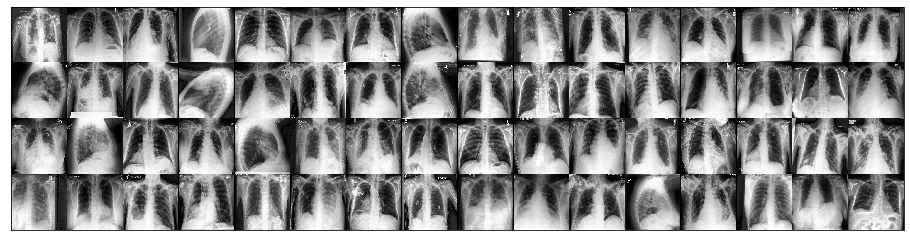

In [65]:
train_loader, valid_loader = get_dloaders(64, 2**13, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

#### CLAHE p=0.5 (bz=64, sampsz=8k)

In [96]:
train_loader, valid_loader = get_dloaders(64, 2**13, seed=404)
show_batch(train_loader,denorm=True)

criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

Resize(always_apply=False, p=1, height=256, width=256, interpolation=1)
RandomCrop(always_apply=False, p=1.0, height=244, width=244)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None)
Trainable: 2, Frozen: 362


Score improved: 0.80425 > 0.00000
Epoch [0] train_loss: 0.4126, train_auc: 0.7760, valid_loss: 0.4085, valid_auc: 0.8043


Score improved: 0.81820 > 0.80425
Epoch [1] train_loss: 0.3920, train_auc: 0.7999, valid_loss: 0.3978, valid_auc: 0.8182


Score improved: 0.82616 > 0.81820
Epoch [2] train_loss: 0.3867, train_auc: 0.8077, valid_loss: 0.3925, valid_auc: 0.8262


Score improved: 0.82756 > 0.82616
Epoch [3] train_loss: 0.3833, train_auc: 0.8120, valid_loss: 0.3913, valid_auc: 0.8276


Score improved: 0.82874 > 0.82756
Epoch [4] train_loss: 0.3810, train_auc: 0.8152, valid_loss: 0.3902, valid_auc: 0.8287



#### CLAHE p=0.5 (bz=64, sampsz=65k)

==================== Augmentations ====================
Resize(always_apply=False, p=1, height=256, width=256, interpolation=1)
RandomCrop(always_apply=False, p=1.0, height=244, width=244)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None)
-------------------------------------------------------


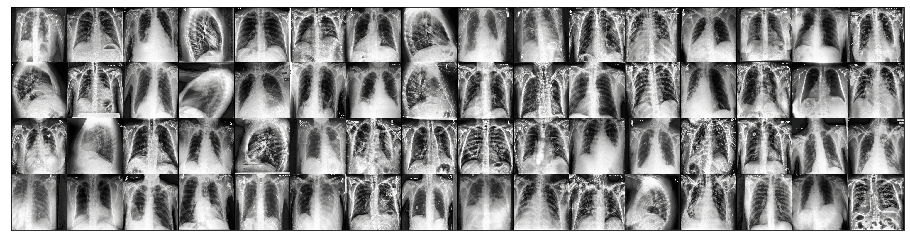

Trainable: 2, Frozen: 362


Score improved: 0.83055 > 0.00000
Epoch [0] train_loss: 0.3853, train_auc: 0.8084, valid_loss: 0.3968, valid_auc: 0.8306


Score improved: 0.83064 > 0.83055
Epoch [1] train_loss: 0.3795, train_auc: 0.8162, valid_loss: 0.3965, valid_auc: 0.8306


Score improved: 0.83409 > 0.83064
Epoch [2] train_loss: 0.3784, train_auc: 0.8176, valid_loss: 0.3949, valid_auc: 0.8341


Epoch [3] train_loss: 0.3779, train_auc: 0.8182, valid_loss: 0.3958, valid_auc: 0.8329


Epoch [4] train_loss: 0.3777, train_auc: 0.8184, valid_loss: 0.3942, valid_auc: 0.8337



In [110]:
train_loader, valid_loader = get_dloaders(64, 2**17, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

#### CLAHE p=1 (bz=64, sampsz=8k)

In [62]:
train_loader, valid_loader = get_dloaders(64, 2**13, seed=404)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

Trainable: 2, Frozen: 362


Score improved: 0.80209 > 0.00000
Epoch [0] train_loss: 0.4130, train_auc: 0.7752, valid_loss: 0.4124, valid_auc: 0.8021


Score improved: 0.81266 > 0.80209
Epoch [1] train_loss: 0.3917, train_auc: 0.8004, valid_loss: 0.4063, valid_auc: 0.8127


Score improved: 0.81872 > 0.81266
Epoch [2] train_loss: 0.3862, train_auc: 0.8082, valid_loss: 0.4021, valid_auc: 0.8187


Epoch [3] train_loss: 0.3840, train_auc: 0.8113, valid_loss: 0.4033, valid_auc: 0.8163


Epoch [4] train_loss: 0.3810, train_auc: 0.8155, valid_loss: 0.4037, valid_auc: 0.8163



#### Additional Transforms (Rotate ±7, sampsz=16k)

==================== Augmentations ====================
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


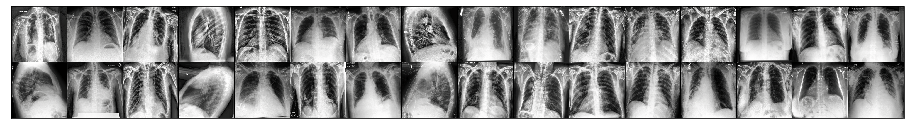

Trainable: 2, Frozen: 362


Score improved: 0.81970 > 0.00000
Epoch [0] train_loss: 0.3999, train_auc: 0.7903, valid_loss: 0.3971, valid_auc: 0.8197


Score improved: 0.82233 > 0.81970
Epoch [1] train_loss: 0.3848, train_auc: 0.8101, valid_loss: 0.3943, valid_auc: 0.8223


Epoch [2] train_loss: 0.3802, train_auc: 0.8161, valid_loss: 0.3938, valid_auc: 0.8220


Epoch [3] train_loss: 0.3776, train_auc: 0.8195, valid_loss: 0.3940, valid_auc: 0.8221


Epoch [4] train_loss: 0.3758, train_auc: 0.8217, valid_loss: 0.3944, valid_auc: 0.8214

CPU times: user 10min 9s, sys: 2min 35s, total: 12min 44s
Wall time: 12min 44s


{'train_loss': [0.3998727794918867,
  0.38477726841618026,
  0.3802274038964089,
  0.3775962113390294,
  0.3758429990413936],
 'train_auc': [0.7903078510108029,
  0.8101094978594954,
  0.8160868436078621,
  0.8194503043113421,
  0.8217040874760151],
 'valid_loss': [0.3970837165699214,
  0.394277077040074,
  0.3938484901494343,
  0.394007743495986,
  0.39437563643911244],
 'valid_auc': [0.8196963938606319,
  0.822328631654831,
  0.8220483309667928,
  0.8220846194419635,
  0.821435263791199]}

In [160]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)
plot_learning_curves(hist)

#### Additional Transforms (Rotate ±7, sampsz=32k)

==================== Augmentations ====================
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


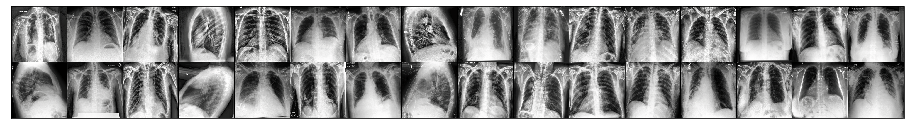

Trainable: 2, Frozen: 362


Score improved: 0.80298 > 0.00000
Epoch [0] train_loss: 0.3940, train_auc: 0.7982, valid_loss: 0.4095, valid_auc: 0.8030


Score improved: 0.80666 > 0.80298
Epoch [1] train_loss: 0.3831, train_auc: 0.8127, valid_loss: 0.4075, valid_auc: 0.8067


Score improved: 0.80773 > 0.80666
Epoch [2] train_loss: 0.3805, train_auc: 0.8161, valid_loss: 0.4072, valid_auc: 0.8077


Epoch [3] train_loss: 0.3791, train_auc: 0.8179, valid_loss: 0.4074, valid_auc: 0.8076


Epoch [4] train_loss: 0.3783, train_auc: 0.8190, valid_loss: 0.4077, valid_auc: 0.8073

CPU times: user 20min 11s, sys: 5min 9s, total: 25min 21s
Wall time: 24min 34s


{'train_loss': [0.39401699350736324,
  0.38306745883336885,
  0.3804727785609525,
  0.3791404530154141,
  0.3783180024189723],
 'train_auc': [0.7982215324432758,
  0.812662149198418,
  0.8161066053004334,
  0.817896744450577,
  0.8190013651083076],
 'valid_loss': [0.4094701585955536,
  0.40747309756110406,
  0.4072440941237136,
  0.4074268278675528,
  0.40768890810650305],
 'valid_auc': [0.8029772813492797,
  0.80665852317238,
  0.8077314478930284,
  0.8076286300183335,
  0.8072732456655017]}

In [161]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**15, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)
hist

#### Additional Transforms (IAAAffine shear ±5, Rotate ±7)

==================== Augmentations ====================
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


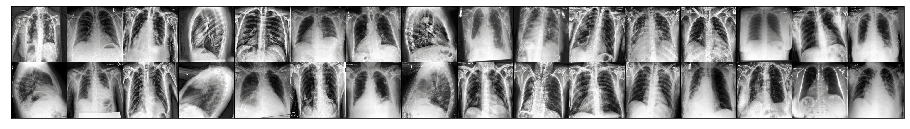

Trainable: 2, Frozen: 362


Score improved: 0.81605 > 0.00000
Epoch [0] train_loss: 0.4004, train_auc: 0.7896, valid_loss: 0.3998, valid_auc: 0.8160


Score improved: 0.81790 > 0.81605
Epoch [1] train_loss: 0.3857, train_auc: 0.8089, valid_loss: 0.3977, valid_auc: 0.8179


Epoch [2] train_loss: 0.3813, train_auc: 0.8149, valid_loss: 0.3974, valid_auc: 0.8173


Epoch [3] train_loss: 0.3787, train_auc: 0.8183, valid_loss: 0.3977, valid_auc: 0.8169


Epoch [4] train_loss: 0.3769, train_auc: 0.8205, valid_loss: 0.3980, valid_auc: 0.8164



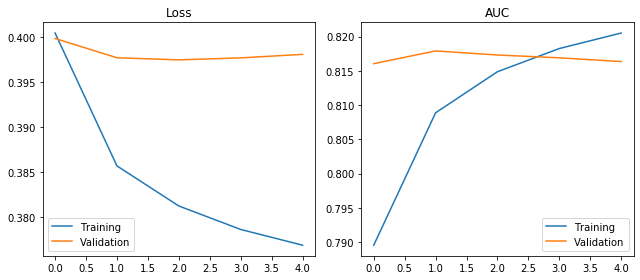

CPU times: user 10min 11s, sys: 2min 36s, total: 12min 47s
Wall time: 12min 28s


In [178]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)
plot_learning_curves(hist)

#### Additional Transforms (IAAAffine shear ±10, Rotate ±7)

==================== Augmentations ====================
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-10, 10), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


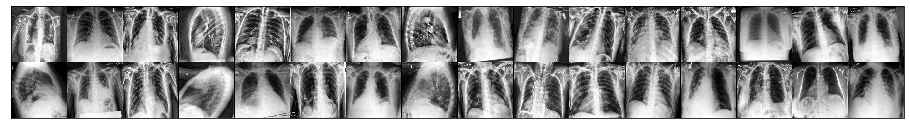

Trainable: 2, Frozen: 362


Score improved: 0.81702 > 0.00000
Epoch [0] train_loss: 0.4008, train_auc: 0.7892, valid_loss: 0.3994, valid_auc: 0.8170


Score improved: 0.81902 > 0.81702
Epoch [1] train_loss: 0.3861, train_auc: 0.8086, valid_loss: 0.3967, valid_auc: 0.8190


Score improved: 0.81915 > 0.81902
Epoch [2] train_loss: 0.3817, train_auc: 0.8145, valid_loss: 0.3963, valid_auc: 0.8192


Epoch [3] train_loss: 0.3791, train_auc: 0.8179, valid_loss: 0.3964, valid_auc: 0.8187


Epoch [4] train_loss: 0.3773, train_auc: 0.8202, valid_loss: 0.3967, valid_auc: 0.8182



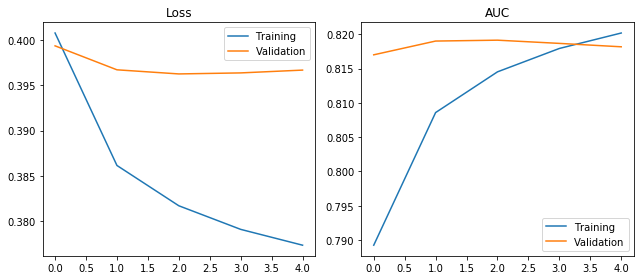

CPU times: user 10min 27s, sys: 2min 22s, total: 12min 50s
Wall time: 12min 52s


In [19]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)
plot_learning_curves(hist)

### Template matching

==================== Augmentations ====================
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


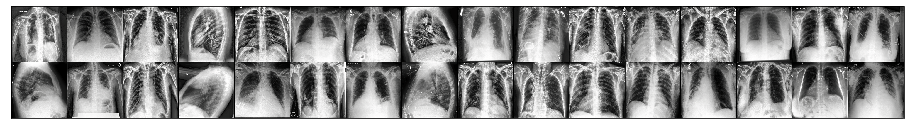

Trainable: 2, Frozen: 362


Score improved: 0.81530 > 0.00000
Epoch [0] train_loss: 0.3992, train_auc: 0.7914, valid_loss: 0.4003, valid_auc: 0.8153


Score improved: 0.81814 > 0.81530
Epoch [1] train_loss: 0.3842, train_auc: 0.8111, valid_loss: 0.3976, valid_auc: 0.8181


Epoch [2] train_loss: 0.3797, train_auc: 0.8171, valid_loss: 0.3972, valid_auc: 0.8181


Epoch [3] train_loss: 0.3771, train_auc: 0.8204, valid_loss: 0.3974, valid_auc: 0.8178


Epoch [4] train_loss: 0.3754, train_auc: 0.8226, valid_loss: 0.3978, valid_auc: 0.8180

CPU times: user 10min 9s, sys: 2min 35s, total: 12min 45s
Wall time: 13min 4s


{'train_loss': [0.399193438111748,
  0.38422191667956146,
  0.3797162536999783,
  0.37710478851637574,
  0.3753622892951722],
 'train_auc': [0.7913751595596458,
  0.8111454047857252,
  0.817064284780585,
  0.8204023020215474,
  0.8226406755916182],
 'valid_loss': [0.4002823865585429,
  0.3975930990644231,
  0.3972419898170817,
  0.39744895308537154,
  0.3978338970436964],
 'valid_auc': [0.8152957397957453,
  0.8181359306398946,
  0.8180654686594688,
  0.8178274134898235,
  0.8179512047947908]}

In [132]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)
hist